In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier, plot_importance


c:\Users\rache\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("data/daily_crsp.csv")
df


C:\Users\rache\AppData\Local\Temp\ipykernel_1672\1510176756.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/daily_crsp.csv")


,PERMNO,HdrCUSIP,CUSIP,Ticker,TradingSymbol,PERMCO,SICCD,NAICS,DlyCalDt,DlyRet,sprtrn
0,10001,36720410,29274A10,EWST,EWST,7953,4920,0,2000-01-03,0.007353,-0.009549
1,10001,36720410,29274A10,EWST,EWST,7953,4920,0,2000-01-04,-0.014599,-0.038345
2,10001,36720410,29274A10,EWST,EWST,7953,4920,0,2000-01-05,0.014815,0.001922
3,10001,36720410,29274A10,EWST,EWST,7953,4920,0,2000-01-06,-0.007299,0.000956
4,10001,36720410,29274A10,EWST,EWST,7953,4920,0,2000-01-07,-0.007353,0.027090
...,...,...,...,...,...,...,...,...,...,...,...
47333136,93436,88160R10,88160R10,TSLA,TSLA,53453,9999,336110,2024-12-24,0.073572,0.011043
47333137,93436,88160R10,88160R10,TSLA,TSLA,53453,9999,336110,2024-12-26,-0.017630,-0.000406
47333138,93436,88160R10,88160R10,TSLA,TSLA,53453,9999,336110,2024-12-27,-0.049479,-0.011056
47333139,93436,88160R10,88160R10,TSLA,TSLA,53453,9999,336110,2024-12-30,-0.033012,-0.010702


In [4]:
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)

fix_seed(42)

In [5]:
IR = pd.read_csv("data/FRB_H15.csv")
IR

,Series Description,4-week Treasury bill secondary market rate discount basis
0,Unit:,Percent:_Per_Year
1,Multiplier:,1
2,Currency:,NaN
3,Unique Identifier:,H15/H15/RIFSGFSW04_N.B
4,Time Period,RIFSGFSW04_N.B
...,...,...
6112,2024-12-26,4.26
6113,2024-12-27,4.25
6114,2024-12-30,4.25
6115,2024-12-31,4.22


In [6]:
# data cleaning
sprtrn_series = df[['DlyCalDt', 'sprtrn']].drop_duplicates().sort_values('DlyCalDt')
sprtrn_series['DlyCalDt'] = pd.to_datetime(sprtrn_series['DlyCalDt'])
sprtrn_series = sprtrn_series.set_index('DlyCalDt').sort_index()

# Monthly return
# Compute target based on the last 20 calendar days of each month
sprtrn_series['month'] = sprtrn_series.index.to_period('M')
last_10d = sprtrn_series.groupby('month').tail(11)
last_10d_returns = last_10d.groupby('month')['sprtrn'].sum()
labels = (last_10d_returns > 0).astype(int).rename("target")
labels.index = labels.index.to_timestamp(how='end')
labels.index = labels.index.normalize()

# 10 first days of each month, our first predictor
first_10d = sprtrn_series.groupby('month').head(11)

# predictors
monthly_features = first_10d.groupby('month')['sprtrn'].agg([
    ('mean_ret_10d', 'mean'),
    ('std_ret_10d', 'std'),
    ('min_ret_10d', 'min'),
    ('max_ret_10d', 'max'),
    ('sum_ret_10d', 'sum')
])
monthly_features.index = monthly_features.index.to_timestamp(how='end')  # align to month-end for merging

# data cleaning 2
IR.columns = ['Date', 'IR']
IR = IR.iloc[6:].dropna()
IR['Date'] = pd.to_datetime(IR['Date'])
IR['IR'] = pd.to_numeric(IR['IR'], errors='coerce')
IR = IR.dropna().set_index('Date').sort_index()

# monthly
monthly_ir = IR['IR'].resample('ME').first()
monthly_ir_change = monthly_ir.diff().rename("IR_change")

# finalising
monthly_features.index = monthly_features.index.normalize()
monthly_ir.index = monthly_ir.index.normalize()
labels.index = labels.index.normalize()
X = monthly_features.copy()
X = X.merge(monthly_ir, left_index=True, right_index=True)
X = X.merge(monthly_ir_change, left_index=True, right_index=True)
X = X.merge(labels, left_index=True, right_index=True)
X = X.dropna()
X


,mean_ret_10d,std_ret_10d,min_ret_10d,max_ret_10d,sum_ret_10d,IR,IR_change,target
2001-09-30,-0.010788,0.022739,-0.049216,0.038983,-0.118669,3.38,-0.22,0
2001-10-31,0.004250,0.011179,-0.008344,0.022938,0.046751,2.21,-1.17,0
2001-11-30,0.006871,0.008952,-0.002735,0.022948,0.075582,2.15,-0.06,0
2001-12-31,-0.000343,0.011911,-0.015868,0.022318,-0.003768,1.83,-0.32,1
2002-01-31,-0.001608,0.008041,-0.016245,0.009180,-0.017687,1.71,-0.12,0
...,...,...,...,...,...,...,...,...
2024-08-31,0.000467,0.016431,-0.029969,0.023043,0.005137,5.28,0.00,1
2024-09-30,-0.000172,0.010543,-0.021151,0.011580,-0.001889,5.16,-0.12,1
2024-10-31,0.000855,0.007462,-0.009586,0.009689,0.009400,4.76,-0.40,0
2024-11-30,0.002644,0.010138,-0.013203,0.025296,0.029086,4.57,-0.19,1


In [7]:
y = X['target']
X_features = X.drop(columns=['target'])
split_idx = int(0.8 * len(X))
X_train, X_test = X_features.iloc[:split_idx], X_features.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix (confident predictions only):
[[ 7  9]
 [ 8 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.44      0.45        16
           1       0.73      0.75      0.74        32

    accuracy                           0.65        48
   macro avg       0.60      0.59      0.60        48
weighted avg       0.64      0.65      0.64        48


Neutral predictions (abstained): 8 / 56


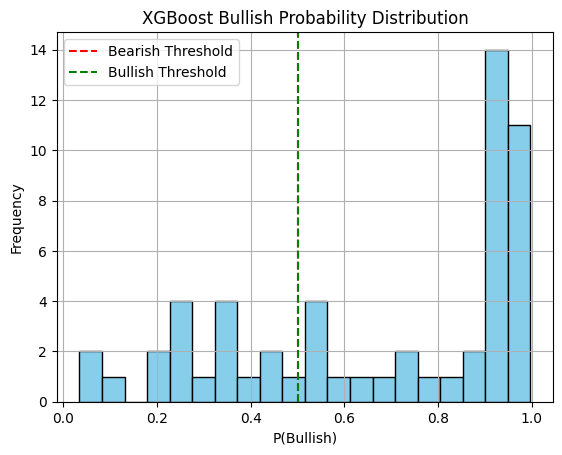

In [8]:
# 1. Training
model = XGBClassifier(
    scale_pos_weight=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:, 1]

#  Custom classification IF NEEDED
def classify_regime(p, low=0.4, high=0.6):
    if p < low:
        return 0  # Bearish
    elif p > high:
        return 1  # Bullish
    else:
        return 2  # Neutral

preds_custom = np.array([classify_regime(p) for p in probs])

# Keep only confident predictions (0 or 1)
mask = preds_custom != 2
y_true_conf = y_test[mask]
y_pred_conf = preds_custom[mask]

# Confusion matrix on confident predictions only
print("Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1]))
print("\nClassification Report:")
print(classification_report(y_true_conf, y_pred_conf, labels=[0, 1]))

# Neutral summary
neutral_count = (preds_custom == 2).sum()
print(f"\nNeutral predictions (abstained): {neutral_count} / {len(preds_custom)}")

#probability distribution
plt.hist(probs, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.5, color='green', linestyle='--', label='Bullish Threshold')
plt.title("XGBoost Bullish Probability Distribution")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced' 
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [10]:
lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',  
    max_iter=1000            
)
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [11]:
# Predict
rf_preds = rf_model.predict(X_test)
lr_preds = lr_model.predict(X_test)

# Evaluate
print("Random Forest:")
print(classification_report(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))

print("Logistic Regression:")
print(classification_report(y_test, lr_preds))
print(confusion_matrix(y_test, lr_preds))

Random Forest:
              precision    recall  f1-score   support

           0       0.30      0.15      0.20        20
           1       0.63      0.81      0.71        36

    accuracy                           0.57        56
   macro avg       0.47      0.48      0.45        56
weighted avg       0.51      0.57      0.53        56

[[ 3 17]
 [ 7 29]]
Logistic Regression:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49        20
           1       0.71      0.69      0.70        36

    accuracy                           0.62        56
   macro avg       0.60      0.60      0.60        56
weighted avg       0.63      0.62      0.63        56

[[10 10]
 [11 25]]


In [12]:
print(y_train.value_counts(normalize=True))

target
1    0.611607
0    0.388393
Name: proportion, dtype: float64


In [13]:
y = X['target']
X_features = X.drop(columns=['target'])
split_idx = int(0.8 * len(X))
X_train, X_test = X_features.iloc[:split_idx], X_features.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix (confident predictions only):
[[ 9  6]
 [ 7 18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        15
           1       0.75      0.72      0.73        25

    accuracy                           0.68        40
   macro avg       0.66      0.66      0.66        40
weighted avg       0.68      0.68      0.68        40


Neutral predictions (abstained): 16 / 56


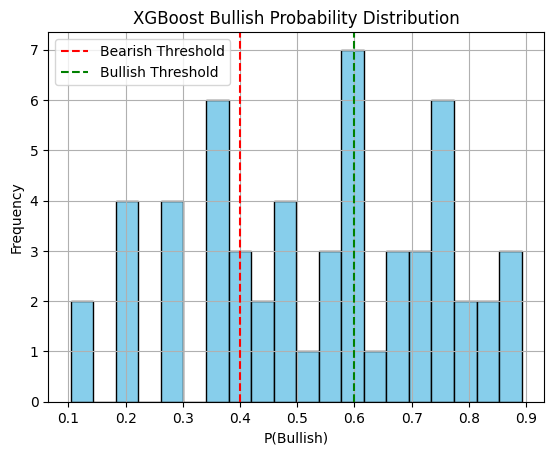

In [14]:
model = XGBClassifier(
    reg_alpha=0.2,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    learning_rate=0.05,
    n_estimators=400,
    scale_pos_weight=0.42,  # Adjusting for class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
) 

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]


#  Custom classification IF NEEDED
def classify_regime(p, low=0.4, high=0.6):
    if p < low:
        return 0  # Bearish
    elif p > high:
        return 1  # Bullish
    else:
        return 2  # Neutral

preds_custom = np.array([classify_regime(p) for p in probs])

# Keep only confident predictions (0 or 1)
mask = preds_custom != 2
y_true_conf = y_test[mask]
y_pred_conf = preds_custom[mask]

# Confusion matrix on confident predictions only
print("Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1]))
print("\nClassification Report:")
print(classification_report(y_true_conf, y_pred_conf, labels=[0, 1]))

# Neutral summary
neutral_count = (preds_custom == 2).sum()
print(f"\nNeutral predictions (abstained): {neutral_count} / {len(preds_custom)}")

#probability distribution
plt.hist(probs, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.4, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.6, color='green', linestyle='--', label='Bullish Threshold')
plt.title("XGBoost Bullish Probability Distribution")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

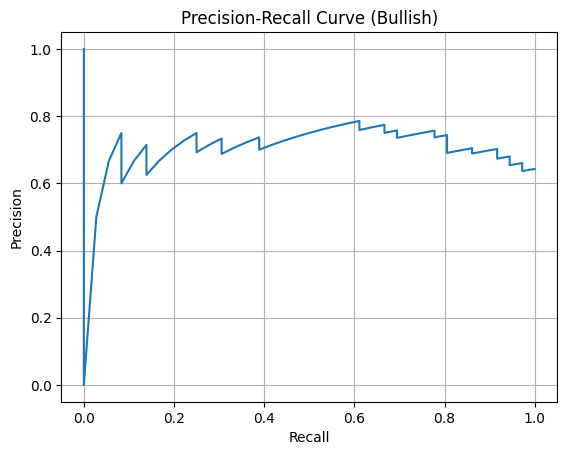

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve (Bullish)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


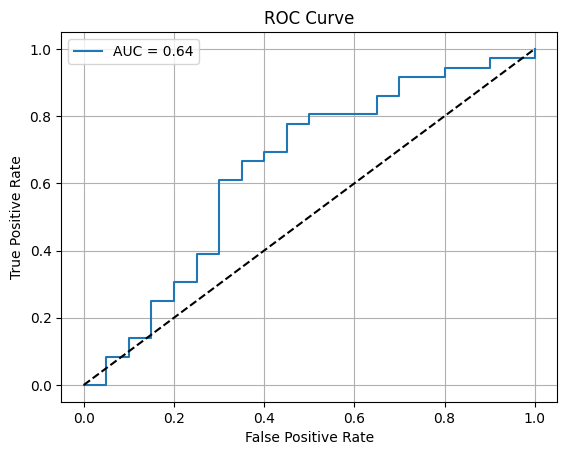

In [16]:
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


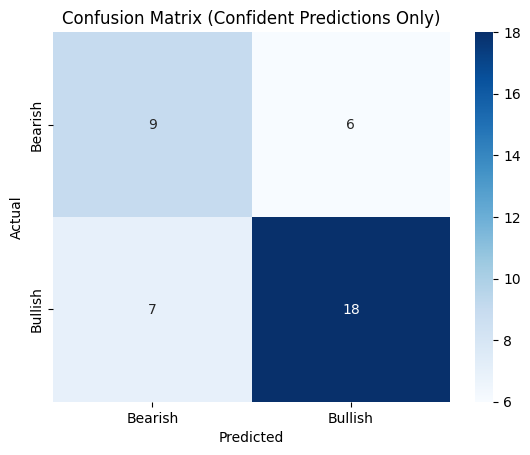

In [17]:
cm = confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bearish', 'Bullish'], yticklabels=['Bearish', 'Bullish'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Confident Predictions Only)')
plt.show()


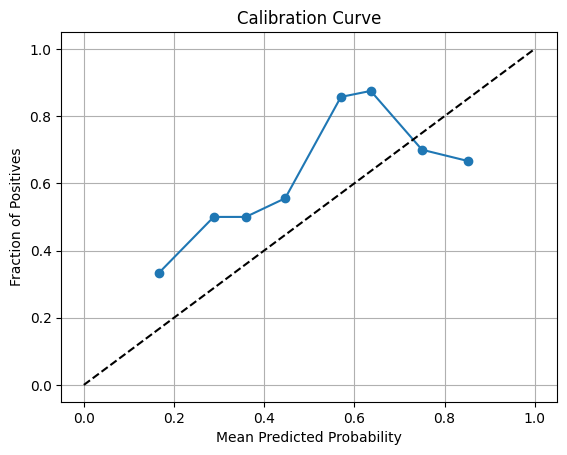

In [18]:
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.grid(True)
plt.show()

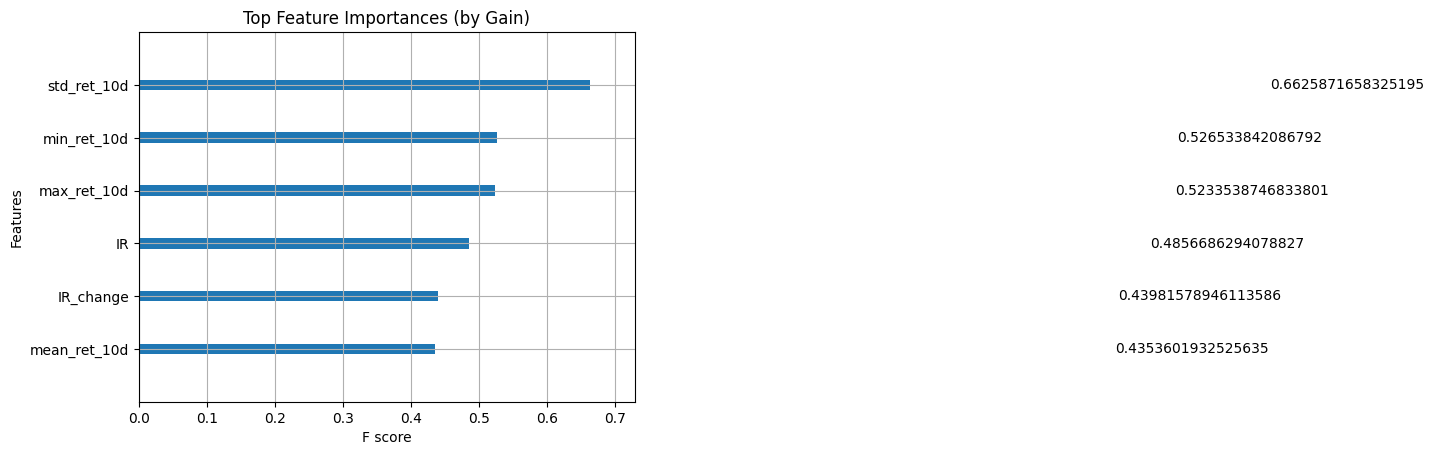

In [19]:
plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top Feature Importances (by Gain)")
plt.show()

C:\Users\rache\AppData\Local\Temp\ipykernel_1672\2099739501.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


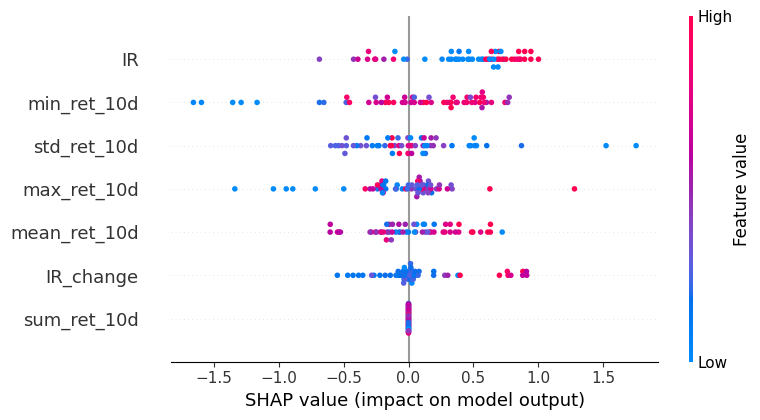

In [20]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rache\miniconda3\lib\site-packa

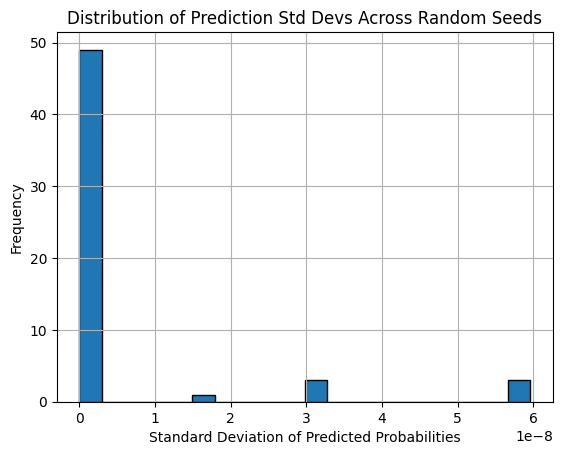

In [21]:
pred_matrix = []

for seed in range(5):
    model = XGBClassifier(
        reg_alpha=0.2,
        reg_lambda=1,
        gamma=0,
        max_depth=3,
        learning_rate=0.05,
        n_estimators=500,
        scale_pos_weight=0.42,
        use_label_encoder=False,
        eval_metric='logloss',
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=seed
    )
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    pred_matrix.append(preds)

pred_matrix = np.array(pred_matrix)

#standard deviation across seeds for each sample
stds = np.std(pred_matrix, axis=0)

plt.hist(stds, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Std Devs Across Random Seeds")
plt.xlabel("Standard Deviation of Predicted Probabilities")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Confusion Matrix (confident predictions only):
[[ 0 19]
 [ 0 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.64      1.00      0.78        34

    accuracy                           0.64        53
   macro avg       0.32      0.50      0.39        53
weighted avg       0.41      0.64      0.50        53


Neutral predictions (abstained): 3 / 56


c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


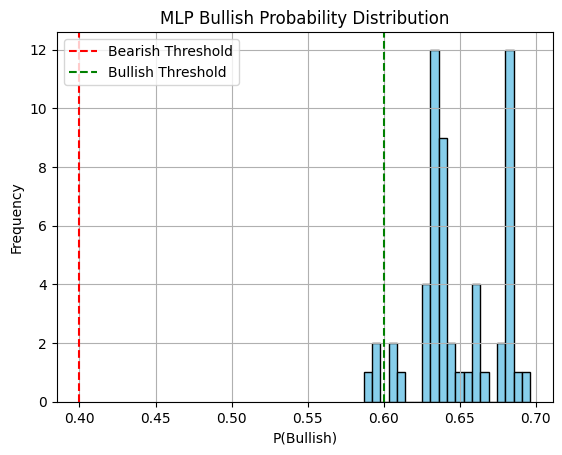

In [22]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Define MLP
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
model = MLP(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict probabilities
model.eval()
with torch.no_grad():
    probs = model(X_test_tensor).numpy().flatten()

# Custom classification
def classify_regime(p, low=0.4, high=0.6):
    if p < low:
        return 0  # Bearish
    elif p > high:
        return 1  # Bullish
    else:
        return 2  # Neutral

preds_custom = np.array([classify_regime(p) for p in probs])

# Confident predictions
mask = preds_custom != 2
y_true_conf = y_test[mask]
y_pred_conf = preds_custom[mask]

# Evaluation
print("Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1]))
print("\nClassification Report:")
print(classification_report(y_true_conf, y_pred_conf, labels=[0, 1]))

# Neutral summary
neutral_count = (preds_custom == 2).sum()
print(f"\nNeutral predictions (abstained): {neutral_count} / {len(preds_custom)}")

# Plot probability distribution
plt.hist(probs, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.4, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.6, color='green', linestyle='--', label='Bullish Threshold')
plt.title("MLP Bullish Probability Distribution")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix (confident predictions only):
[[20  0]
 [36  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53        20
           1       0.00      0.00      0.00        36

    accuracy                           0.36        56
   macro avg       0.18      0.50      0.26        56
weighted avg       0.13      0.36      0.19        56


Neutral predictions (abstained): 0 / 56


c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


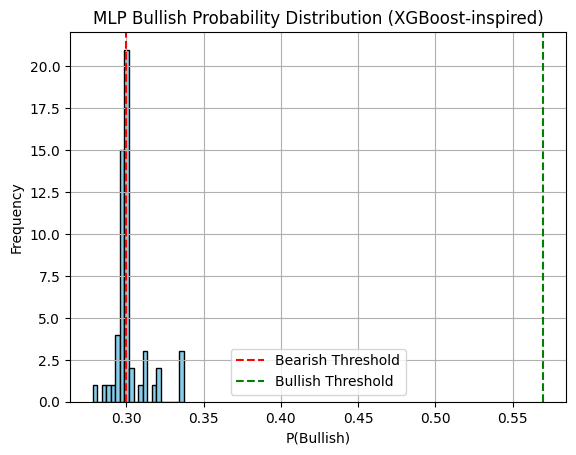

In [23]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  
        )

    def forward(self, x):
        return self.net(x)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum() * 0.42])  # 0.42 like XGBoost
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model = MLP(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(75):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(X_test_tensor)).numpy().flatten()

def classify_regime(p, low=0.4, high=0.6):
    if p < low:
        return 0  # Bearish
    elif p > high:
        return 1  # Bullish
    else:
        return 2  # Neutral

preds_custom = np.array([classify_regime(p) for p in probs])

mask = preds_custom != 2
y_true_conf = y_test[mask]
y_pred_conf = preds_custom[mask]

print("Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1]))
print("\nClassification Report:")
print(classification_report(y_true_conf, y_pred_conf, labels=[0, 1]))

neutral_count = (preds_custom == 2).sum()
print(f"\nNeutral predictions (abstained): {neutral_count} / {len(preds_custom)}")

plt.hist(probs, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.3, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.57, color='green', linestyle='--', label='Bullish Threshold')
plt.title("MLP Bullish Probability Distribution (XGBoost-inspired)")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Confusion Matrix (confident predictions only):
[[ 7  6]
 [ 5 18]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        13
           1       0.75      0.78      0.77        23

    accuracy                           0.69        36
   macro avg       0.67      0.66      0.66        36
weighted avg       0.69      0.69      0.69        36

Accuracy: 69.44%
Neutral predictions: 20 / 56


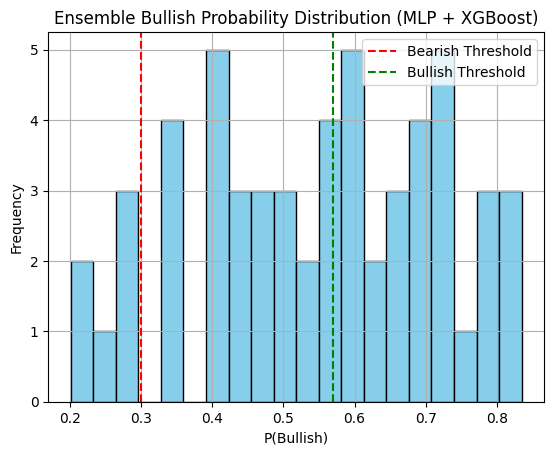

In [24]:
xgb_model = XGBClassifier(
    reg_alpha=0.2,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    learning_rate=0.05,
    n_estimators=400,
    scale_pos_weight=0.42,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

class SoftMLP(nn.Module):
    def __init__(self, input_dim):
        super(SoftMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_soft = y_train.replace({0: 0.2, 1: 0.8}).values.astype(np.float32)
y_train_tensor = torch.tensor(y_train_soft).view(-1, 1)

soft_model = SoftMLP(input_dim=X_train.shape[1])
optimizer = optim.Adam(soft_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(150):
    soft_model.train()
    optimizer.zero_grad()
    output = soft_model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

soft_model.eval()
with torch.no_grad():
    mlp_probs = soft_model(X_test_tensor).numpy().flatten()

ensemble_probs = 0.8 * xgb_probs + 0.2 * mlp_probs


def classify_regime(p, low=0.4, high=0.6):
    if p < low:
        return 0  # Bearish
    elif p > high:
        return 1  # Bullish
    else:
        return 2  # Neutral

ensemble_preds = np.array([classify_regime(p) for p in ensemble_probs])

mask = ensemble_preds != 2
y_true_conf = y_test[mask]
y_pred_conf = ensemble_preds[mask]

print(" Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1]))
print("\n Classification Report:")
print(classification_report(y_true_conf, y_pred_conf, labels=[0, 1]))
print(f"Accuracy: {accuracy_score(y_true_conf, y_pred_conf):.2%}")
print(f"Neutral predictions: {(ensemble_preds == 2).sum()} / {len(ensemble_preds)}")

plt.hist(ensemble_probs, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.3, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.57, color='green', linestyle='--', label='Bullish Threshold')
plt.title("Ensemble Bullish Probability Distribution (MLP + XGBoost)")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


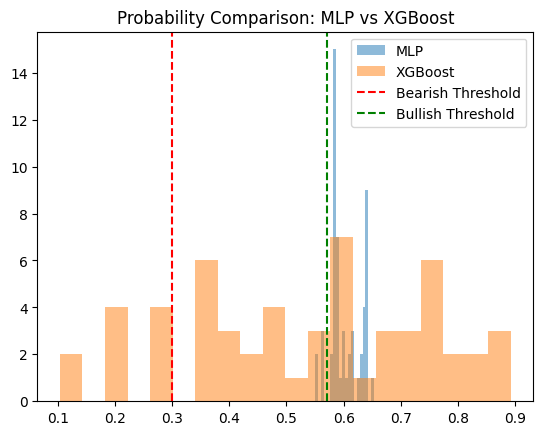

In [25]:
plt.hist(mlp_probs, bins=20, alpha=0.5, label="MLP")
plt.hist(xgb_probs, bins=20, alpha=0.5, label="XGBoost")
plt.axvline(0.3, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.57, color='green', linestyle='--', label='Bullish Threshold')
plt.legend()
plt.title("Probability Comparison: MLP vs XGBoost")
plt.show()


c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix (confident predictions only):
[[0 0]
 [0 0]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       0.0
   macro avg       0.00      0.00      0.00       0.0
weighted avg       0.00      0.00      0.00       0.0

Accuracy: nan%
Neutral predictions: 56 / 56
Bearish predictions: 56


c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\lib\site-pac

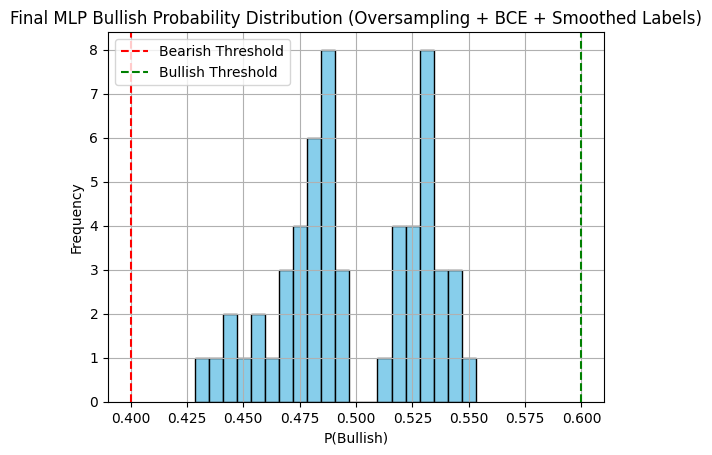

In [26]:
xgb_model = XGBClassifier(
    reg_alpha=0.2,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    learning_rate=0.05,
    n_estimators=500,
    scale_pos_weight=0.42,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

class BetterMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Output logits
        )

    def forward(self, x):
        return self.net(x)

X_0 = X_train[y_train == 0]
X_1 = X_train[y_train == 1]
X_0_oversampled = X_0.sample(len(X_1), replace=True)

X_balanced = pd.concat([X_0_oversampled, X_1])
y_balanced = pd.Series([0]*len(X_1) + [1]*len(X_1))  # Equal 0/1

y_balanced_tensor = torch.tensor(
    y_balanced.replace({0: 0.05, 1: 0.95}).values.astype(np.float32)
).view(-1, 1)

X_train_tensor = torch.tensor(X_balanced.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

soft_model = BetterMLP(input_dim=X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(soft_model.parameters(), lr=0.001)

for epoch in range(200):
    soft_model.train()
    optimizer.zero_grad()
    logits = soft_model(X_train_tensor)
    loss = criterion(logits, y_balanced_tensor)
    loss.backward()
    optimizer.step()

soft_model.eval()
with torch.no_grad():
    probs = torch.sigmoid(soft_model(X_test_tensor)).numpy().flatten()

def classify_regime(p, low=0.4, high=0.6):
    if p < low:
        return 0  # Bearish
    elif p > high:
        return 1  # Bullish
    else:
        return 2  # Neutral

preds_custom = np.array([classify_regime(p) for p in probs])

mask = preds_custom != 2
y_true_conf = y_test[mask]
y_pred_conf = preds_custom[mask]

print("Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1]))
print("\n Classification Report:")
print(classification_report(y_true_conf, y_pred_conf, labels=[0, 1]))
print(f"Accuracy: {accuracy_score(y_true_conf, y_pred_conf):.2%}")
print(f"Neutral predictions: {(preds_custom == 2).sum()} / {len(preds_custom)}")
print(f"Bearish predictions: {(probs < 4).sum()}")

plt.hist(probs, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.4, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.6, color='green', linestyle='--', label='Bullish Threshold')
plt.title("Final MLP Bullish Probability Distribution (Oversampling + BCE + Smoothed Labels)")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

 Confusion Matrix (confident predictions only):
[[ 8  5]
 [10  8]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.62      0.52        13
           1       0.62      0.44      0.52        18

    accuracy                           0.52        31
   macro avg       0.53      0.53      0.52        31
weighted avg       0.54      0.52      0.52        31

 Accuracy: 51.61%
 Neutral predictions: 25 / 56
 Bearish predictions: 18


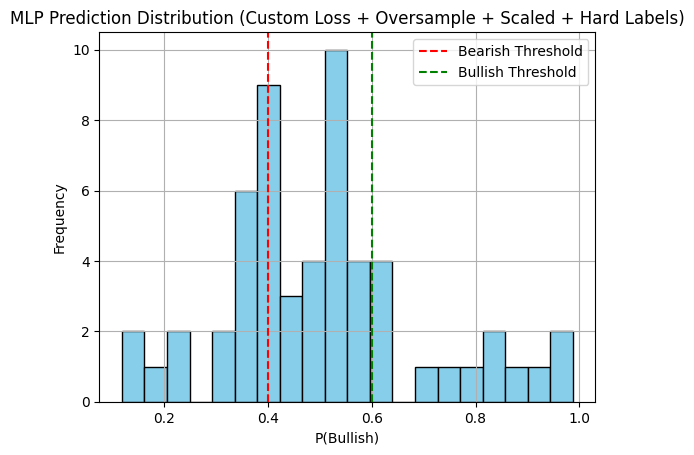

In [27]:
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)

fix_seed(42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train_scaled.index = y_train.index  

class BetterMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  
        )

    def forward(self, x):
        return self.net(x)

class AsymmetricFocalBCE(nn.Module):
    def __init__(self, alpha=3.0, beta=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.view(-1, 1)
        bce = nn.functional.binary_cross_entropy(probs, targets, reduction='none')
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma
        class_weight = torch.where(targets == 1, self.beta, self.alpha)
        loss = class_weight * focal_weight * bce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

X_0 = X_train_scaled[y_train == 0]
X_1 = X_train_scaled[y_train == 1]
X_0_oversampled = X_0.sample(len(X_1), replace=True)
X_balanced = pd.concat([X_0_oversampled, X_1])
y_balanced = pd.Series([0]*len(X_1) + [1]*len(X_1)) 

X_train_tensor = torch.tensor(X_balanced.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_balanced.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

model = BetterMLP(input_dim=X_train.shape[1])
criterion = AsymmetricFocalBCE(alpha=3.0, beta=1.0, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(X_test_tensor)).numpy().flatten()

def classify_regime(p, low=0.4, high=0.6):
    if p < low:
        return 0  # Bearish
    elif p > high:
        return 1  # Bullish
    else:
        return 2  # Neutral

preds_custom = np.array([classify_regime(p) for p in probs])

mask = preds_custom != 2
y_true_conf = y_test[mask]
y_pred_conf = preds_custom[mask]

print(" Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1]))
print("\n Classification Report:")
print(classification_report(y_true_conf, y_pred_conf, labels=[0, 1]))
print(f" Accuracy: {accuracy_score(y_true_conf, y_pred_conf):.2%}")
print(f" Neutral predictions: {(preds_custom == 2).sum()} / {len(preds_custom)}")
print(f" Bearish predictions: {(probs < 0.4).sum()}")

plt.hist(probs, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.4, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.6, color='green', linestyle='--', label='Bullish Threshold')
plt.title("MLP Prediction Distribution (Custom Loss + Oversample + Scaled + Hard Labels)")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


 Confusion Matrix (confident predictions only):
[[2 5]
 [5 8]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.29      0.29         7
           1       0.62      0.62      0.62        13

    accuracy                           0.50        20
   macro avg       0.45      0.45      0.45        20
weighted avg       0.50      0.50      0.50        20

 Accuracy: 50.00%
 Neutral predictions: 36 / 56
 Bearish predictions: 2


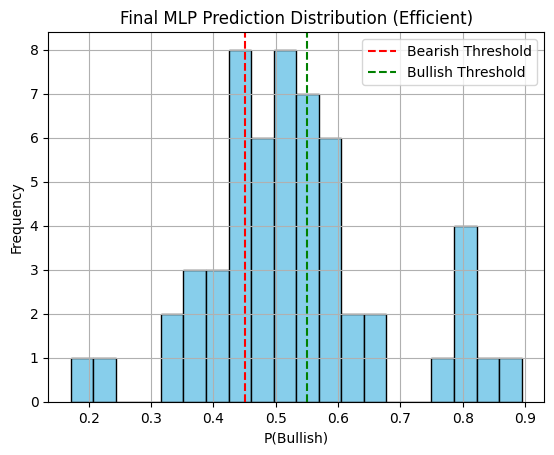

In [28]:
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)

fix_seed(42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_0 = X_train_scaled[y_train == 0]
X_1 = X_train_scaled[y_train == 1]

X_0_over = X_0.sample(len(X_1) , replace=True, random_state=42)

X_bal = pd.concat([X_0_over, X_1])

y_bal = pd.Series([0] * len(X_0_over) + [1] * len(X_1), index=X_bal.index)


X_train_tensor = torch.tensor(X_bal.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_bal.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class EfficientMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.01),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class AsymmetricFocalBCE(nn.Module):
    def __init__(self, alpha=2, beta=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.view(-1, 1)
        bce = nn.functional.binary_cross_entropy(probs, targets, reduction='none')
        pt = torch.where(targets == 1, probs, 1 - probs)
        weight = (1 - pt) ** self.gamma
        class_weight = torch.where(targets == 1, self.beta, self.alpha)
        return (class_weight * weight * bce).mean()

model = EfficientMLP(input_dim=X_train.shape[1])
criterion = AsymmetricFocalBCE()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

for epoch in range(400):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(X_test_tensor)).numpy().flatten()

def classify_regime(p, low=0.4, high=0.6):
    if p < low: return 0
    elif p > high: return 1
    else: return 2

preds = np.array([classify_regime(p) for p in probs])
mask = preds != 2
y_conf = y_test[mask]
y_pred = preds[mask]

print(" Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_conf, y_pred, labels=[0, 1]))
print("\n Classification Report:")
print(classification_report(y_conf, y_pred, labels=[0, 1]))
print(f" Accuracy: {accuracy_score(y_conf, y_pred):.2%}")
print(f" Neutral predictions: {(preds == 2).sum()} / {len(preds)}")
print(f" Bearish predictions: {(probs < 0.3).sum()}")

plt.hist(probs, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.45, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.55, color='green', linestyle='--', label='Bullish Threshold')
plt.title("Final MLP Prediction Distribution (Efficient)")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\rache\AppData\Local\Temp\ipykernel_1672\2840164842.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['xgb_pred'] = xgb_probs_train
C:\Users\rache\AppData\Local\Temp\ipykernel_1672\2840164842.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Confusion Matrix (confident predictions only):
[[10  8]
 [ 6 26]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        18
           1       0.76      0.81      0.79        32

    accuracy                           0.72        50
   macro avg       0.69      0.68      0.69        50
weighted avg       0.71      0.72      0.72        50

 Accuracy: 72.00%
 Neutral predictions: 6 / 56
 Bearish predictions: 15


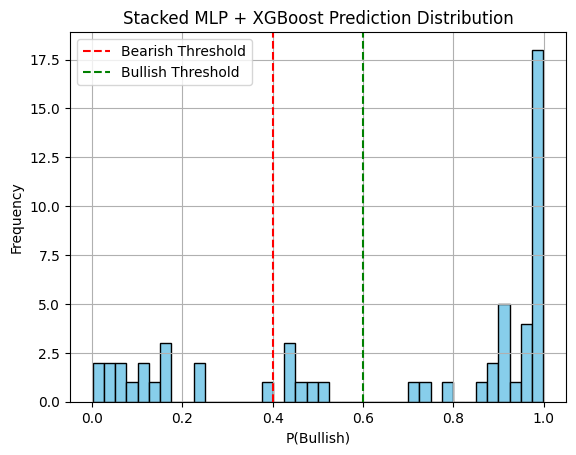

In [29]:
y = X['target']
X_features = X.drop(columns=['target'])
split_idx = int(0.8 * len(X))
X_train, X_test = X_features.iloc[:split_idx], X_features.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
a=42

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seed(a)

xgb = XGBClassifier(
    reg_alpha=0.2,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    learning_rate=0.05,
    n_estimators=400,
    scale_pos_weight=0.42,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=a
)
xgb.fit(X_train, y_train)
xgb_probs_train = xgb.predict_proba(X_train)[:, 1]
xgb_probs_test = xgb.predict_proba(X_test)[:, 1]

X_train['xgb_pred'] = xgb_probs_train
X_test['xgb_pred'] = xgb_probs_test

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_0 = X_train_scaled[y_train == 0]
X_1 = X_train_scaled[y_train == 1]
X_0_over = X_0.sample(len(X_1) * 2, replace=True, random_state=a)
X_bal = pd.concat([X_0_over, X_1])
y_bal = pd.Series([0] * len(X_0_over) + [1] * len(X_1), index=X_bal.index)

X_train_tensor = torch.tensor(X_bal.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_bal.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator().manual_seed(a) 
)

class EfficientMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 1)
        )
        

    def forward(self, x):
        return self.net(x)

class AsymmetricFocalBCE(nn.Module):
    def __init__(self, alpha=2, beta=1, gamma=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.view(-1, 1)
        bce = nn.functional.binary_cross_entropy(probs, targets, reduction='none')
        pt = torch.where(targets == 1, probs, 1 - probs)
        weight = (1 - pt) ** self.gamma
        class_weight = torch.where(targets == 1, self.beta, self.alpha)
        return (class_weight * weight * bce).mean()

model = EfficientMLP(input_dim=X_train_scaled.shape[1])
criterion = AsymmetricFocalBCE()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(200):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(X_test_tensor)).numpy().flatten()

def classify_regime(p, low=0.4 , high=0.6):
    if p < low: return 0
    elif p > high: return 1
    else: return 2

preds = np.array([classify_regime(p) for p in probs])
mask = preds != 2
y_conf = y_test[mask]
y_pred = preds[mask]

print("Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_conf, y_pred, labels=[0, 1]))
print("\n Classification Report:")
print(classification_report(y_conf, y_pred, labels=[0, 1]))
print(f" Accuracy: {accuracy_score(y_conf, y_pred):.2%}")
print(f" Neutral predictions: {(preds == 2).sum()} / {len(preds)}")
print(f" Bearish predictions: {(probs < 0.3).sum()}")

plt.hist(probs, bins=40, color='skyblue', edgecolor='black')
plt.axvline(0.4, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.6, color='green', linestyle='--', label='Bullish Threshold')
plt.title("Stacked MLP + XGBoost Prediction Distribution")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix (confident predictions only):
[[ 3  5]
 [ 1 17]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.77      0.94      0.85        18

    accuracy                           0.77        26
   macro avg       0.76      0.66      0.68        26
weighted avg       0.77      0.77      0.74        26

 Accuracy: 76.92%
 Neutral predictions: 30 / 56
 Bearish predictions: 15


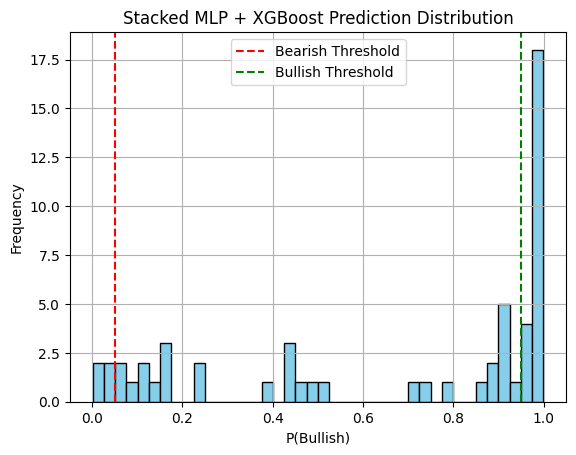

In [30]:
def classify_regime(p, low=0.05 , high=0.95):
    if p < low: return 0
    elif p > high: return 1
    else: return 2

preds = np.array([classify_regime(p) for p in probs])
mask = preds != 2
y_conf = y_test[mask]
y_pred = preds[mask]

print("Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_conf, y_pred, labels=[0, 1]))
print("\n Classification Report:")
print(classification_report(y_conf, y_pred, labels=[0, 1]))
print(f" Accuracy: {accuracy_score(y_conf, y_pred):.2%}")
print(f" Neutral predictions: {(preds == 2).sum()} / {len(preds)}")
print(f" Bearish predictions: {(probs < 0.3).sum()}")

plt.hist(probs, bins=40, color='skyblue', edgecolor='black')
plt.axvline(0.05, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.95, color='green', linestyle='--', label='Bullish Threshold')
plt.title("Stacked MLP + XGBoost Prediction Distribution")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


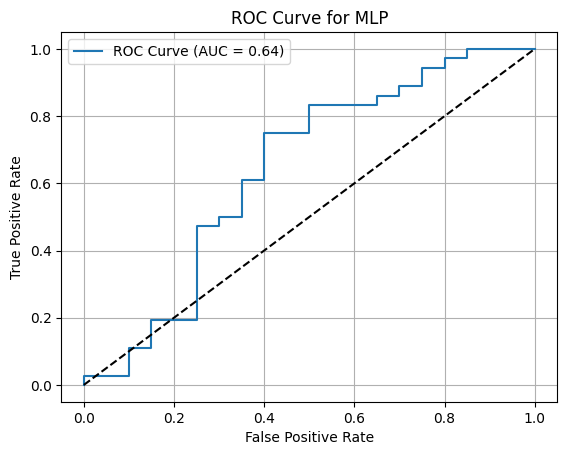

In [31]:
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend()
plt.grid(True)
plt.show()


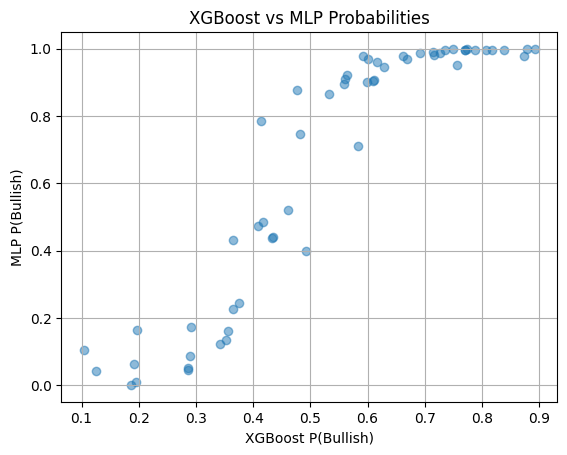

In [32]:
plt.scatter(xgb_probs_test, probs, alpha=0.5)
plt.xlabel('XGBoost P(Bullish)')
plt.ylabel('MLP P(Bullish)')
plt.title('XGBoost vs MLP Probabilities')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

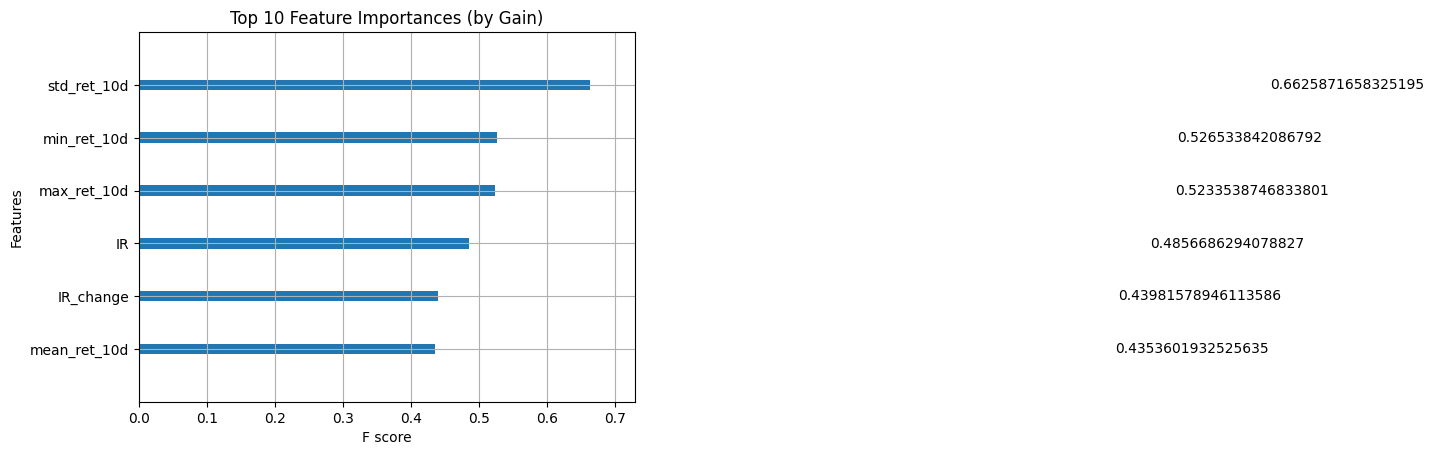

In [33]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances (by Gain)")
plt.grid(True)
plt.show()


c:\Users\rache\miniconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Confusion Matrix (confident predictions only):
[[ 4  4]
 [ 2 13]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.76      0.87      0.81        15

    accuracy                           0.74        23
   macro avg       0.72      0.68      0.69        23
weighted avg       0.73      0.74      0.73        23

 Accuracy: 73.91%
 Neutral predictions: 33 / 56
 Bearish predictions: 2


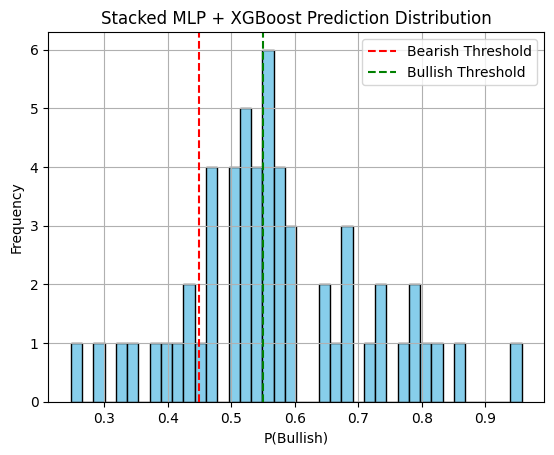

In [34]:
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seed(42)

y = X['target']
X_features = X.drop(columns=['target'])
split_idx = int(0.8 * len(X))
X_train_full, X_test = X_features.iloc[:split_idx], X_features.iloc[split_idx:]
y_train_full, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

split_idx_2 = int(0.75 * len(X_train_full))
X_train_1, X_train_2 = X_train_full.iloc[:split_idx_2], X_train_full.iloc[split_idx_2:]
y_train_1, y_train_2 = y_train_full.iloc[:split_idx_2], y_train_full.iloc[split_idx_2:]

xgb = XGBClassifier(
    reg_alpha=0.2,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    learning_rate=0.05,
    n_estimators=400,
    scale_pos_weight=0.42,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_1, y_train_1)
xgb_probs_train_2 = xgb.predict_proba(X_train_2)[:, 1]
xgb_probs_test = xgb.predict_proba(X_test)[:, 1]

X_train_2 = X_train_2.copy()
X_test = X_test.copy()
X_train_2['xgb_pred'] = xgb_probs_train_2
X_test['xgb_pred'] = xgb_probs_test

y_train_2 = y_train_2.copy()

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_2), columns=X_train_2.columns, index=X_train_2.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_0 = X_train_scaled[y_train_2 == 0]
X_1 = X_train_scaled[y_train_2 == 1]
X_0_over = X_0.sample(len(X_1) * 2, replace=True, random_state=42)
X_bal = pd.concat([X_0_over, X_1])
y_bal = pd.Series([0] * len(X_0_over) + [1] * len(X_1), index=X_bal.index)

X_train_tensor = torch.tensor(X_bal.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_bal.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator().manual_seed(42)
)

class EfficientMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

class AsymmetricFocalBCE(nn.Module):
    def __init__(self, alpha=1, beta=2, gamma=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.view(-1, 1)
        bce = nn.functional.binary_cross_entropy(probs, targets, reduction='none')
        pt = torch.where(targets == 1, probs, 1 - probs)
        weight = (1 - pt) ** self.gamma
        class_weight = torch.where(targets == 1, self.beta, self.alpha)
        return (class_weight * weight * bce).mean()

model = EfficientMLP(input_dim=X_train_scaled.shape[1])
criterion = AsymmetricFocalBCE()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(200):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(X_test_tensor)).numpy().flatten()

def classify_regime(p, low=0.4 , high=0.6):
    if p < low: return 0
    elif p > high: return 1
    else: return 2

preds = np.array([classify_regime(p) for p in probs])
mask = preds != 2
y_conf = y_test[mask]
y_pred = preds[mask]

print(" Confusion Matrix (confident predictions only):")
print(confusion_matrix(y_conf, y_pred, labels=[0, 1]))
print("\n Classification Report:")
print(classification_report(y_conf, y_pred, labels=[0, 1]))
print(f" Accuracy: {accuracy_score(y_conf, y_pred):.2%}")
print(f" Neutral predictions: {(preds == 2).sum()} / {len(preds)}")
print(f" Bearish predictions: {(probs < 0.3).sum()}")

plt.hist(probs, bins=40, color='skyblue', edgecolor='black')
plt.axvline(0.45, color='red', linestyle='--', label='Bearish Threshold')
plt.axvline(0.55, color='green', linestyle='--', label='Bullish Threshold')
plt.title("Stacked MLP + XGBoost Prediction Distribution")
plt.xlabel("P(Bullish)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

